<a href="https://colab.research.google.com/github/hockyy/pytorch-explore-facedata/blob/main/Tugas_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas 2

Silahkan dikerjakan di google colab dengan cara mengupload notebook ini dan folder dataset (unzip lebih dahulu) kedalam folder Colab Notebooks. Atau bisa dikerjakan di komputer yang sudah menginstall Pytorch 


Nama: **Hocky Yudhiono**

NPM: **1906285604**

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [7]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks


In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch import optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

print("Using torch", torch.__version__)
torch.manual_seed(42) # Setting the seed

Using torch 1.11.0+cu113


# Prepare Dataset and Functions

In [9]:
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((48,48)),
        transforms.ToTensor()
    ]),

    'Testing': transforms.Compose([
        transforms.Resize((48,48)),
        transforms.ToTensor()
    ]),
}

# sesuaikan untuk menuju folder FaceData
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/FaceData'
#

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['Female', 'Male']

In [10]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, num_epochs=25):
    phase='Training'
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train() 

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders['Training']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

In [11]:

from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def test_model(model):
    model.eval()
    phase = 'Testing'

    y_true = []
    y_pred = []

    for inputs, labels in tqdm(dataloaders['Testing']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            prob, pred = torch.max(outputs, 1)
            y_true.append(labels.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    print("Classification Report: \n", classification_report(y_true, y_pred))
    plt.figure(figsize=(5,5))
    ax = plt.subplot(1,1,1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(ax=ax)
    plt.show()
    # TASK
    # gunakan fungsi confusion_matrix(y_true, y_pred) untuk membantu kalian menghitung
    # akurasi, presisi, recall, f1-score, sensitivity dan specificity

# Create Model from Scratch

Disini kita akan membangun model Image Classification dengan arsitektur VGG menggunakan Pytorch. Dibawah ini adalah tabel yang berisi arsitektur VGG16, yaitu spesifikasi layer-layer beserta dengan activation functionnya 

<img src="https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/config2.jpg" alt="drawing" width="500"/>

# Building Blocks
Sebelum kita membuat model, kita akan mempelajari bagian-bagian dari sebuah Image Classification model, seperti convolution layer, pooling layer, activation function, dropout, dan fully connected network.

Pada tugas ini, kita akan membangun model menggunakan teknik sequential, sehingga setiap layer akan disusun sesuai urutan dia dimasukkan. setiap layer pada model akan dimasukkan kedalam Sequential()

<a href='https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html'>Dokumentasi Pytorch</a>

In [ ]:
model = nn.Sequential()

Building block pertama yang perlu diperlajari adalah Convolution layer.

`Conv2d(n_input_channel, n_output_channel, kernel_size=(K, K), stride=S, padding=P)`

Contoh:

`nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1)`

berarti layer convolution diatas berekspektasi jumlah channel yang dia terima berjumlah 3, dan jumlah filter (kernel) / feature map / output channel yang dihasilkan ada 64, dengan ukuran tiap filter nya 3x3, dan dengan stride = 1 dan padding = 1

In [ ]:
model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1)
    )

Untuk menambahkan activation function, dilakukan dengan cara menambahkan layer di model setelah convolution layer. Pada kasus ini, convolutional layer memiliki fungsi aktivasi ReLU

In [ ]:
model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.ReLU(inplace=True)
    )

Layer selanjutnya yang perlu dipelajari adalah Pooling layer. Pada VGG, jenis pooling yang dipakai adalah MaxPooling

`MaxPool2d(kernel_size=K, stride=S, padding=P)`

Contoh:

`MaxPool2d(kernel_size=2, stride=2, padding=0)`

MaxPooling layer diatas akan memiliki ukuran kernel 2x2, dengan stride = 1, padding = 0. Sama dengan layer lainnya, MaxPooling layer akan dimasukkan kedalam sequential


In [ ]:
model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.ReLU(inplace=True),
    )

Setelah kita membuat struktur convolutional network, kita perlu menyiapkan supaya bisa diolah kedalam Fully Connected Network. Salah satu caranya adalah dengan menggunakan Flatten, yang mengubah tensor dimensi apapun menjadi 1 dimensi

`nn.Flatten()`

Dimensi dari output Flatten layer dihitung dari dimensi input (C, W, H) menjadi (C\*W\*H), dengan C = jumlah Channel, W = width, H = height. Contoh:

dimensi input = 3, 48, 48

dimensi ouput = 3\*48\*48 = 6912

In [ ]:
model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Flatten()
    )

Setelah itu kita bisa menambahkan fully connected layer, yang tediri dari linear layer dengan activation function

`nn.Linear(in_features, out_features)`

in_features adalah dimensi dari input layer linear dan harus dihitung berdasarkan dimensi output dari layer sebelumnya. dimensi output sebuah layer akan berubah dari dimensi awal nya, berdasarkan ukuran kernel, strides dan padding. Untuk menetapkan activation pada linear layer, bisa dilakukan dengan menambahkan nn.ReLU atau nn.Sigmoid setelah linear layer nya.

In [ ]:
model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Flatten(),
        nn.Linear(1024, 512), # misal 1024, 512
        nn.ReLU(inplace=True),
        nn.Linear(512, 2) # misal 512, 2
    )


<img src='https://qph.fs.quoracdn.net/main-qimg-d4023fe66cac95238a76ea1b5bc21d84-pjlq'>

Pada output layer, kita biasanya menetapkan activation function yang sesuai dengan loss function yang akan digunakan, jika menggunakan Sigmoid activation, kita akan menggunakan binary crossentropy sebagai loss function nya. dan jika menggunakan SoftMax activation, kita menggunakan categorical cross entropy sebagai loss function. namun pada case Pytorch, lebih baik tidak menetapkan activation function pada output layer model kita jika kita menggunakan categorical cross entropy. lebih lengkapnya bisa di google sendiri dan lihat disini : <a href='https://stackoverflow.com/questions/57516027/does-pytorch-apply-softmax-automatically-in-nn-linear'>https://stackoverflow.com/questions/57516027/does-pytorch-apply-softmax-automatically-in-nn-linear</a>

## Build-a-model

\[TASK\] Lengkapi tabel berikut


| Input |    Layer    | Feature Map | Input Size | Kernel Size | Output Size | Stride | Padding | Activation |
|:-----:|:-----------:|:-----------:|:----------:|:-----------:|:-----------:|:------:|:-------:|:----------:|
|   1   | Convolution |      64     |   48x48x3  |     5x5     |   46x46x64  |    1   |    1    |    ReLU    |
|   2   | Convolution |      64     |  46x46x64  |     3x3     |   44x44x64  |    1   |    0    |    ReLU    |
|   3   |  MaxPooling |      64     |  44x44x64  |     2x2     |   22x22x64  |    2   |    0    |    -    |
|   4   | Convolution |     128     |  22x22x64  |     5x5     |   20x20x128  |    1   |    1    |    ReLU    |
|   5   | Convolution |     128     |  20x20x128  |     3x3     |   20x20x128  |    1   |    1    |    ReLU    |
|   6   |  MaxPooling |     128     |  20x20x128  |     2x2     |   10x10x128  |    2   |    0    |    -    |
|       |   Flatten   |      -      |  10x10x128  |      -      |   12800 |    -   |    -    |      -     |
|   7   |      FC     |      -      |  12800  |      -      |     1024    |    -   |    -    |    Relu    |
|   8   |      FC     |      -      |    1024    |      -      |      2      |    -   |    -    |   SoftMax  |

\[TASK\] Buatlah sebuah model berdasarkan spesifikasi di tabel diatas

In [ ]:
# TASK
model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(5, 5), stride=1, padding=1), # 1 conv
            nn.ReLU(inplace=True),  # 1 act
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=0), # 1 conv
            nn.ReLU(inplace=True),  # 1 act
            nn.MaxPool2d(2, stride=2), # Max pool

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=1, padding=1), # 1 conv
            nn.ReLU(inplace=True),  # 1 act
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1), # 1 conv
            nn.ReLU(inplace=True),  # 1 act
            nn.MaxPool2d(2, stride=2), # Max pool
            
            nn.Flatten(),
            nn.Linear(12800, 1024), # 7 fc
            nn.ReLU(inplace=True), # 7 act
            nn.Linear(1024, 2) # 8 fc
            )

from torchsummary import summary
summary(model.cuda(), (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 46, 46]           4,864
              ReLU-2           [-1, 64, 46, 46]               0
            Conv2d-3           [-1, 64, 44, 44]          36,928
              ReLU-4           [-1, 64, 44, 44]               0
         MaxPool2d-5           [-1, 64, 22, 22]               0
            Conv2d-6          [-1, 128, 20, 20]         204,928
              ReLU-7          [-1, 128, 20, 20]               0
            Conv2d-8          [-1, 128, 20, 20]         147,584
              ReLU-9          [-1, 128, 20, 20]               0
        MaxPool2d-10          [-1, 128, 10, 10]               0
          Flatten-11                [-1, 12800]               0
           Linear-12                 [-1, 1024]      13,108,224
             ReLU-13                 [-1, 1024]               0
           Linear-14                   

In [ ]:
# uji coba performa model

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 360/360 [00:07<00:00, 47.69it/s]


Training Loss: 0.6901 Acc: 0.5274
Epoch 1/9
----------


100%|██████████| 360/360 [00:07<00:00, 47.50it/s]


Training Loss: 0.6521 Acc: 0.6247
Epoch 2/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.15it/s]


Training Loss: 0.5844 Acc: 0.7008
Epoch 3/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.20it/s]


Training Loss: 0.4952 Acc: 0.7599
Epoch 4/9
----------


100%|██████████| 360/360 [00:07<00:00, 49.94it/s]


Training Loss: 0.3854 Acc: 0.8350
Epoch 5/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.10it/s]


Training Loss: 0.3259 Acc: 0.8683
Epoch 6/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.40it/s]


Training Loss: 0.2746 Acc: 0.8933
Epoch 7/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.11it/s]


Training Loss: 0.2496 Acc: 0.9090
Epoch 8/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.28it/s]


Training Loss: 0.2268 Acc: 0.9173
Epoch 9/9
----------


100%|██████████| 360/360 [00:07<00:00, 50.38it/s]

Training Loss: 0.2123 Acc: 0.9281

Training complete in 1m 13s


100%|██████████| 40/40 [00:00<00:00, 53.51it/s]


Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       152
           1       0.98      0.95      0.96       168

    accuracy                           0.96       320
   macro avg       0.96      0.96      0.96       320
weighted avg       0.96      0.96      0.96       320



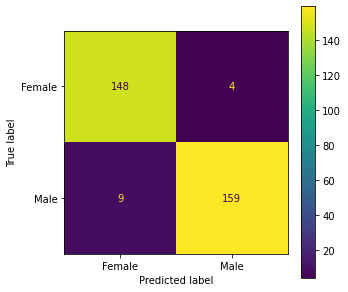

In [ ]:
test_model(model)

# Using Pretrained Model

Salah satu kelebihan machine learning adalah kemampuan untuk 'mendaur ulang' model yang sudah dilatih untuk melakukan task lain. Saya sarankan agar mempelajari dulu mengenai Transfer Learning di youtube atau tempat lainnya

Secara sederhana, Transfer Learning adalah sebuah teknik untuk membuat modifikasi pada model yang sudah dilatih agar model itu bisa melakukan task lain.

Sebagian besar model yang tersedia dilatih pada ImageNet dataset, untuk melakukan klasifikasi pada 1000 kelas pada 14 juta gambar. Kita akan memodifikasi model itu untuk melakukan Gender Prediction dari dataset gambar wajah kita.

In [12]:
vgg16 = models.vgg16() 

model bisa diprint untuk melihat arsitektur nya

In [14]:
print(vgg16)
from torchsummary import summary
summary(vgg16.cuda(), (3, 48, 48))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

kita akan mengganti block classifier supaya model ini memprediksi gender

In [15]:
vgg16.classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=512, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512, out_features=2, bias=True),
    )


In [16]:
print(vgg16)
summary(vgg16.cuda(), (3, 48, 48))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01)

vgg16 = train_model(vgg16, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 137/137 [02:13<00:00,  1.02it/s]


Training Loss: 0.6929 Acc: 0.5119
Epoch 1/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.55it/s]


Training Loss: 0.6923 Acc: 0.5220
Epoch 2/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.64it/s]


Training Loss: 0.6917 Acc: 0.5183
Epoch 3/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.59it/s]


Training Loss: 0.6903 Acc: 0.5238
Epoch 4/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.66it/s]


Training Loss: 0.6849 Acc: 0.5778
Epoch 5/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.49it/s]


Training Loss: 0.6630 Acc: 0.6227
Epoch 6/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.65it/s]


Training Loss: 0.6456 Acc: 0.6429
Epoch 7/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.51it/s]


Training Loss: 0.6202 Acc: 0.6621
Epoch 8/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.59it/s]


Training Loss: 0.5841 Acc: 0.7015
Epoch 9/9
----------


100%|██████████| 137/137 [00:10<00:00, 12.53it/s]

Training Loss: 0.5055 Acc: 0.7756

Training complete in 3m 52s


100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85       152
           1       0.82      0.95      0.88       168

    accuracy                           0.87       320
   macro avg       0.88      0.86      0.86       320
weighted avg       0.87      0.87      0.86       320



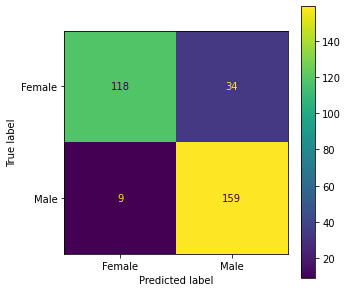

In [18]:
test_model(vgg16)

Ada banyak model lain yang lebih baik dan lebih cepat, silahkan dicoba sendiri

`import torchvision.models as models`

`resnet18 = models.resnet18()`

`alexnet = models.alexnet()`

`vgg16 = models.vgg16()`

`squeezenet = models.squeezenet1_0()`

`densenet = models.densenet161()`


In [19]:
# TASK 

# create a Sequential that has the final layer's output size of 1 neuron and followed by Sigmoid activation function, 
# and assign it as vgg16 classifier

from torchsummary import summary

new_classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=512, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512, out_features=1, bias=True),
    )
vgg16sigmoid = models.vgg16()

vgg16sigmoid.classifier = new_classifier
vgg16sigmoid.to(device)

print(vgg16sigmoid)
summary(vgg16sigmoid.cuda(), (3, 48, 48))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1